# Script utilisé pour la création du dataset

In [88]:
# import os

# # Répertoire contenant les images
# image_dirs = {
#     'train': 'dataset/images/train',
#     'val': 'dataset/images/val'
# }

# # Dictionnaire pour mapper les noms de dossiers aux classes
# class_map = {
#     '1': 1,
#     '2': 2,
#     '3': 3,
#     '4': 4,
#     '5': 5,
#     '6': 6,
#     '7': 7,
#     '8': 8,
#     '9': 9
# }

# # Créer les annotations
# for split, image_dir in image_dirs.items():
#     label_dir = f'dataset/labels/{split}'
#     if not os.path.exists(label_dir):
#         os.makedirs(label_dir)
    
#     for folder in os.listdir(image_dir):
#         class_id = class_map[folder]
#         folder_path = os.path.join(image_dir, folder)
        
#         for img_file in os.listdir(folder_path):
#             if img_file.endswith('.png'):
#                 annotation_path = os.path.join(label_dir, img_file.replace('.png', '.txt'))
#                 with open(annotation_path, 'w') as f:
#                     # Annotation standardisée pour un chiffre centré
#                     f.write(f'{class_id - 1} 0.5 0.5 0.8 0.8\n')
#                 # Déplacer l'image dans le répertoire principal
#                 os.rename(os.path.join(folder_path, img_file), os.path.join(image_dir, img_file))

# # Nettoyer les anciens répertoires
# for split in image_dirs:
#     for folder in class_map:
#         folder_path = os.path.join(image_dirs[split], folder)
#         if os.path.exists(folder_path):
#             os.rmdir(folder_path)


# Détection des contours de l'image, image binaire et découpage des cases

Mean brightness: 147.63936940532986
Gamma: 1.7610478901883868


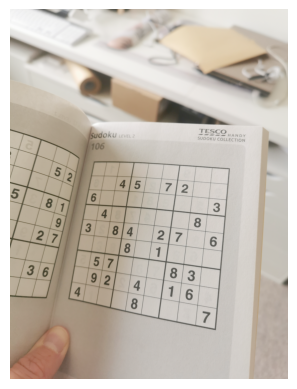

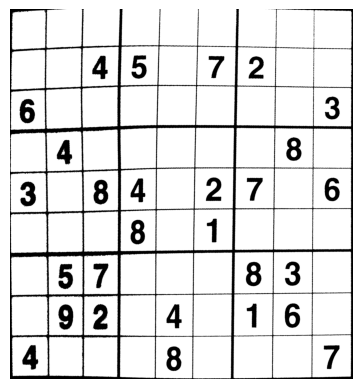

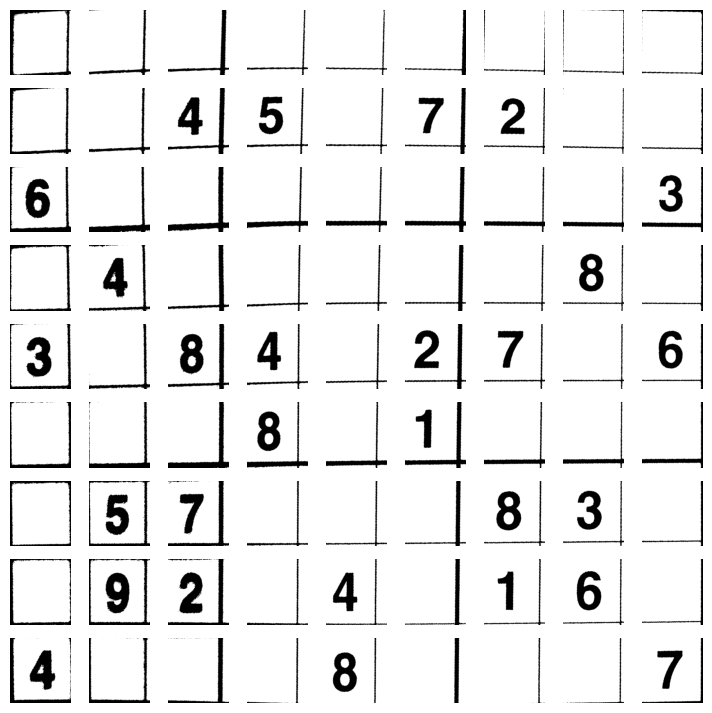

In [197]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_image(image, title=None):
    """
    Affiche une image en utilisant matplotlib.
    
    :param image: Image chargée avec OpenCV.
    :param title: Titre optionnel pour l'image.
    """
    # Convertir l'image de BGR à RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Afficher l'image
    plt.imshow(image_rgb)
    if title:
        plt.title(title)
    plt.axis('off')  # Optionnel : cacher les axes
    plt.show()

def calculate_mean_brightness(image):
    """
    Calcule la luminosité moyenne de l'image.

    :param image: Image chargée avec OpenCV.
    :return: Luminosité moyenne de l'image.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mean_brightness = np.mean(gray)
    return mean_brightness

def determine_gamma(mean_brightness, target_brightness=128):
    """
    Détermine une valeur de gamma basée sur des seuils de luminosité et une correction linéaire.

    :param mean_brightness: Luminosité moyenne de l'image.
    :param target_brightness: Luminosité cible (par défaut 128, milieu de l'échelle de gris).
    :return: Valeur de gamma.
    """
    if mean_brightness >= 165:
        # Luminosité suffisante, ne pas changer l'exposition
        return 1.0
    else:
        # Luminosité insuffisante, appliquer une correction gamma linéaire
        gamma = target_brightness / mean_brightness
        return gamma

def adjust_exposure(image, target_brightness=128):
    """
    Ajuste l'exposition d'une image en utilisant la correction gamma.

    :param image: Image chargée avec OpenCV.
    :param gamma: Valeur de gamma pour ajuster l'exposition (1.0 signifie pas de changement).
    :return: Image avec l'exposition ajustée.
    """
    mean_brightness = calculate_mean_brightness(image)
    gamma = determine_gamma(mean_brightness, target_brightness)
    print(f"Mean brightness: {mean_brightness}")
    print(f"Gamma: {gamma}")
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

def adaptive_threshold(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    adaptive_thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    return adaptive_thresh

def median_blur(image, ksize=5):
    blurred = cv2.medianBlur(image, ksize)
    return blurred

def morphological_transformations(image):
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    return closing

def preprocess_image(img):    
    # Flou médian
    blurred = median_blur(img)
    
    # Seuillage adaptatif
    thresh = adaptive_threshold(blurred)
    
    # Transformations morphologiques
    morph = morphological_transformations(thresh)
    
    # Détection des contours
    edges = cv2.Canny(morph, 50, 100)
    return edges

def find_largest_contour(edges):
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    return largest_contour

def warp_perspective(img, contour):
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    if len(approx) == 4:
        points = approx.reshape(4, 2)
        rect = np.zeros((4, 2), dtype="float32")
        s = points.sum(axis=1)
        rect[0] = points[np.argmin(s)]
        rect[2] = points[np.argmax(s)]
        diff = np.diff(points, axis=1)
        rect[1] = points[np.argmin(diff)]
        rect[3] = points[np.argmax(diff)]
        (tl, tr, br, bl) = rect
        width = max(np.linalg.norm(br - bl), np.linalg.norm(tr - tl))
        height = max(np.linalg.norm(tr - br), np.linalg.norm(tl - bl))
        dst = np.array([
            [0, 0],
            [width - 1, 0],
            [width - 1, height - 1],
            [0, height - 1]], dtype="float32")
        M = cv2.getPerspectiveTransform(rect, dst)
        warped = cv2.warpPerspective(img, M, (int(width), int(height)))
        return warped
    else:
        raise Exception("La grille n'a pas été détectée correctement.")

def extract_cells(warped, grid_size=9):
    cells = []
    cell_height, cell_width = warped.shape[0] // grid_size, warped.shape[1] // grid_size
    for i in range(grid_size):
        row = []
        for j in range(grid_size):
            cell = warped[i * cell_height:(i + 1) * cell_height, j * cell_width:(j + 1) * cell_width]
            row.append(cell)
        cells.append(row)
    return cells

def binary(image):
    # Convertir en niveaux de gris
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Appliquer un seuillage binaire inversé
    _, binary_image = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
    return binary_image

def remove_grid_lines(image):
    """
    Supprime les lignes de grille d'une image de Sudoku.

    :param image: Image chargée avec OpenCV.
    :return: Image sans les lignes de grille.
    """
    # Vérifier si l'image est déjà en niveaux de gris
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    _, binary_image_inv = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

    # Appliquer un flou gaussien
    blurred_mask = cv2.GaussianBlur(binary_image_inv, (5, 5), 0)

    # Détection des contours avec Canny
    mask_edges = cv2.Canny(blurred_mask, 1, 255, apertureSize=3)

    # Détection des lignes avec la transformation de Hough
    lines = cv2.HoughLines(mask_edges, 1, np.pi / 180, 130)
    filtering_mask = np.zeros_like(binary_image_inv)

    # Dessiner les lignes détectées sur un masque
    if lines is not None:
        for rho, theta in lines[:, 0]:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho

            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))

            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            cv2.line(filtering_mask, (x1, y1), (x2, y2), (255, 255, 255), 2)

    # Dilater les lignes détectées
    kernel = np.ones((5, 5), np.uint8)
    filtering_mask = cv2.dilate(filtering_mask, kernel, iterations=2)

    # Soustraction des lignes détectées de l'image originale
    final_mask = cv2.subtract(binary_image_inv, filtering_mask)

    # Convertir en image BGR pour l'affichage
    final_image = cv2.cvtColor(final_mask, cv2.COLOR_GRAY2BGR)

    return final_image


def main(image):
    image = adjust_exposure(image, 260)
    plot_image(image)
    edges = preprocess_image(image)
    largest_contour = find_largest_contour(edges)
    binary_image = binary(image)
    warped = warp_perspective(binary_image, largest_contour)
    plot_image(warped)
    cells = extract_cells(warped)
    return cells

# Exemple d'utilisation
image_path = "sudoku_images/11.jpg"
image = cv2.imread(image_path)

cells = main(image)

# Afficher chaque cellule dans leur configuration d'origine
fig, axs = plt.subplots(9, 9, figsize=(9, 9))
for i in range(9):
    for j in range(9):
        axs[i, j].imshow(cells[i][j], cmap='gray')
        axs[i, j].axis('off')
plt.show()

# Fonction pour rogner les cases

In [198]:
import cv2

def crop_image(image, crop_percentage=0.11):
    if image is None:
        print("Erreur de chargement de l'image")
        return None
    
    # Dimensions de l'image
    height, width = image.shape[:2]
    
    # Calculer les nouvelles dimensions
    crop_height = int(height * crop_percentage)
    crop_width = int(width * crop_percentage)
    
    # Rogner l'image
    cropped_image = image[crop_height:height - crop_height, crop_width:width - crop_width]
    
    return cropped_image

# Exemple d'utilisation
# cells[0][2] = crop_image(cells[0][2])


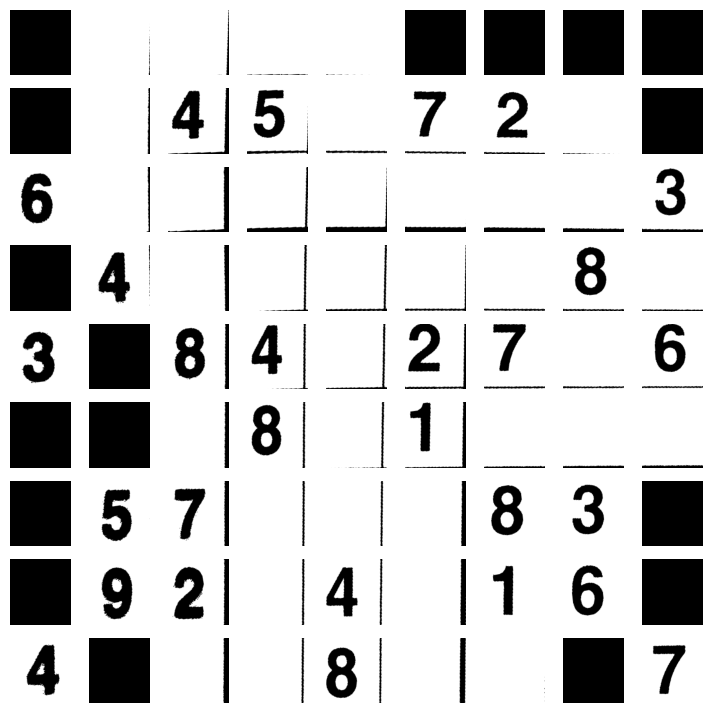

In [199]:
# Afficher chaque cellule dans leur configuration d'origine
cells_crop = [[None for _ in range(9)] for _ in range(9)]
fig, axs = plt.subplots(9, 9, figsize=(9, 9))
for i in range(9):
    for j in range(9):
        cells_crop[i][j] = crop_image(cells[i][j])
        axs[i, j].imshow(cells_crop[i][j], cmap='gray')
        axs[i, j].axis('off')
plt.show()

# Fonction qui décide si une case est vide ou non  

In [200]:
import numpy as np

def is_mostly_white(image, threshold=88):
    """
    Vérifie si une image binaire en niveaux de gris contient plus de 90% de pixels blancs.

    :param image: Image binaire en niveaux de gris.
    :param threshold: Pourcentage de pixels blancs nécessaire pour renvoyer True.
    :return: True si l'image contient plus de 90% de pixels blancs, False sinon.
    """
    # Vérifier si l'image est bien en niveaux de gris
    if len(image.shape) != 2:
        raise ValueError("L'image doit être en niveaux de gris")

    # Compter les pixels blancs
    total_pixels = image.size
    white_pixels = np.sum(image == 255)

    # Calculer le pourcentage de pixels blancs
    white_percentage = (white_pixels / total_pixels) * 100

    return white_percentage > threshold

# Détection des chiffres dans les cases

In [201]:
from ultralytics import YOLO

# Charger le modèle YOLOv8
model = YOLO('models/yolov8n_number.pt')

# Initialiser une grille pour stocker les résultats
detected_grid = [[0 for _ in range(9)] for _ in range(9)]

# Parcourir les cellules de la grille de Sudoku
for i in range(9):
    for j in range(9):
        if (is_mostly_white(cells_crop[i][j])):
            detected_grid[i][j] = 0
            continue
        
        # Effectuer la prédiction sur chaque cellule
        cells_rgb = cv2.cvtColor(cells_crop[i][j], cv2.COLOR_GRAY2BGR)
        results = model(cells_rgb)

        # Extraire le chiffre détecté
        for result in results:
            if result.boxes:
                for box in result.boxes:
                    detected_class = int(box.cls.item())
                    detected_grid[i][j] = detected_class



0: 640x608 1 4, 210.9ms
Speed: 5.3ms preprocess, 210.9ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 608)

0: 640x608 1 5, 113.9ms
Speed: 2.5ms preprocess, 113.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)

0: 640x608 1 7, 95.5ms
Speed: 2.9ms preprocess, 95.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)

0: 640x608 1 2, 103.6ms
Speed: 2.7ms preprocess, 103.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)

0: 640x608 1 6, 105.0ms
Speed: 2.7ms preprocess, 105.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)

0: 640x608 1 3, 95.0ms
Speed: 3.9ms preprocess, 95.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)

0: 640x608 (no detections), 107.1ms
Speed: 2.9ms preprocess, 107.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)

0: 640x608 1 8, 97.4ms
Speed: 2.7ms preprocess, 97.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)

0: 640x60

# Résultat

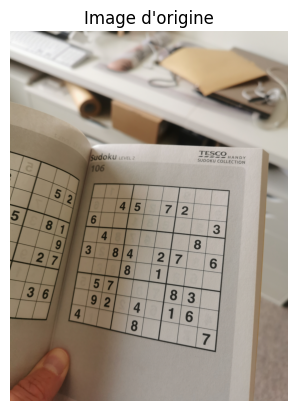

[[0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 4, 5, 0, 7, 2, 0, 0],
 [6, 0, 0, 0, 0, 0, 0, 0, 3],
 [0, 0, 0, 0, 0, 0, 0, 8, 0],
 [3, 0, 8, 4, 0, 2, 7, 0, 6],
 [0, 0, 0, 8, 0, 1, 0, 0, 0],
 [0, 5, 7, 0, 0, 0, 8, 3, 0],
 [0, 9, 2, 0, 4, 0, 1, 6, 0],
 [4, 0, 0, 0, 8, 0, 0, 0, 7]]

In [202]:
plot_image(image, "Image d'origine")
detected_grid